In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
from datetime import datetime
from IPython.display import HTML
from matplotlib import animation

# Ignore some warnings produced by basemap
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# try to import Basemap
try:
    from mpl_toolkits.basemap import Basemap
    has_basemap = True
except ImportError:
    has_basemap = False

# Set the map resolution
# Notice: set resolution to full will make this program time-consuming
map_resolution = "i" # l: low, i: intermediate, h: high, f: full
    
plt.rcParams['figure.figsize'] = (20,5) # fiqure size

# Dataset
PM2.5 Dataset，every data has the following attributes: 
    - PM25: PM2.5 濃度
    - PM10: PM10 濃度
    - PM1 : PM1 濃度
    - Humidity: 溼度
    - Temperature: 溫度
    - DateTime: 時間
    - device_id: 感測器 id
    - record_id: 資料記錄 id
    - lon, lat: 感測器座標

In [2]:
with open('PM2.5.csv', mode='r', encoding='utf-8') as file:
    pm25_data = pd.read_csv(file, parse_dates=['DateTime'])

pm25_data.head()

,record_id,device_id,DateTime,PM25,PM10,PM1,Temperature,Humidity,lat,lon
0,12773,28C2DDDD415C,2017-03-01 08:30:00,43,0,0,19.61,96,23.741,120.755
1,12774,28C2DDDD415C,2017-03-01 09:00:00,41,0,0,19.81,94,23.741,120.755
2,12775,28C2DDDD415C,2017-03-01 09:30:00,41,0,0,19.73,93,23.741,120.755
3,12776,28C2DDDD415C,2017-03-01 10:00:00,47,0,0,19.17,92,23.741,120.755
4,12777,28C2DDDD415C,2017-03-01 10:30:00,50,0,0,19.90,91,23.741,120.755


## Problem Definition
    Use (lon, lat) as the features to observe the PM2.5 device. Find out if there is any relation between the location of the device.

## Data Preprocessing (lon, lat)
    1. Extract the column of lon and lat.
    2. Remove the non-numerical data.
    3. Remove the (lon, lat) that is not in the range of Taiwan.

In [3]:
PM25_frame = pm25_data[['device_id', 'lat', 'lon']].drop_duplicates()
PM25_frame.columns = ['device_id', 'latitude', 'longitude']
PM25_frame.sort_values(by='device_id')
PM25_frame.reset_index(inplace=True)
PM25_frame

,index,device_id,latitude,longitude
0,0,28C2DDDD415C,23.741,120.755
1,1471,28C2DDDD415F,22.996,120.222
2,2740,28C2DDDD423C,24.990,121.576
3,4211,28C2DDDD42C7,24.983,121.534
4,5243,28C2DDDD42F7,24.998,121.539
5,6511,28C2DDDD4343,23.482,120.463
6,7780,28C2DDDD4354,24.990,121.570
7,9246,28C2DDDD4357,24.987,121.550
8,10674,28C2DDDD435A,24.999,121.559
9,12145,28C2DDDD4418,24.976,121.583


In [4]:
def IsNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

#Remove non-numerical data on latitude and longitude
for x in PM25_frame.index:
    if((~IsNumber(PM25_frame['latitude'][x])) or (~IsNumber(PM25_frame['longitude'][x]))):
        PM25_frame.drop(x)
        
#Remove those data that are not in the region of Taiwan
PM25_frame = PM25_frame[(PM25_frame['latitude'] >= 22)]
PM25_frame = PM25_frame[(PM25_frame['latitude'] <= 25)]
PM25_frame = PM25_frame[(PM25_frame['longitude'] >= 120)]
PM25_frame = PM25_frame[(PM25_frame['longitude'] <= 122)]
PM25_frame

,index,device_id,latitude,longitude
0,0,28C2DDDD415C,23.741,120.755
1,1471,28C2DDDD415F,22.996,120.222
2,2740,28C2DDDD423C,24.990,121.576
3,4211,28C2DDDD42C7,24.983,121.534
4,5243,28C2DDDD42F7,24.998,121.539
5,6511,28C2DDDD4343,23.482,120.463
6,7780,28C2DDDD4354,24.990,121.570
7,9246,28C2DDDD4357,24.987,121.550
8,10674,28C2DDDD435A,24.999,121.559
9,12145,28C2DDDD4418,24.976,121.583


# Spatial Clustering(KMeans)

In [5]:
coords = PM25_frame.as_matrix(columns=['latitude', 'longitude'])
coords

array([[ 23.741, 120.755],
       [ 22.996, 120.222],
       [ 24.99 , 121.576],
       ...,
       [ 22.996, 120.226],
       [ 24.784, 121.   ],
       [ 24.748, 120.907]])

In [6]:
#if has_basema
x, y = coords[:, 1], coords[:, 0]

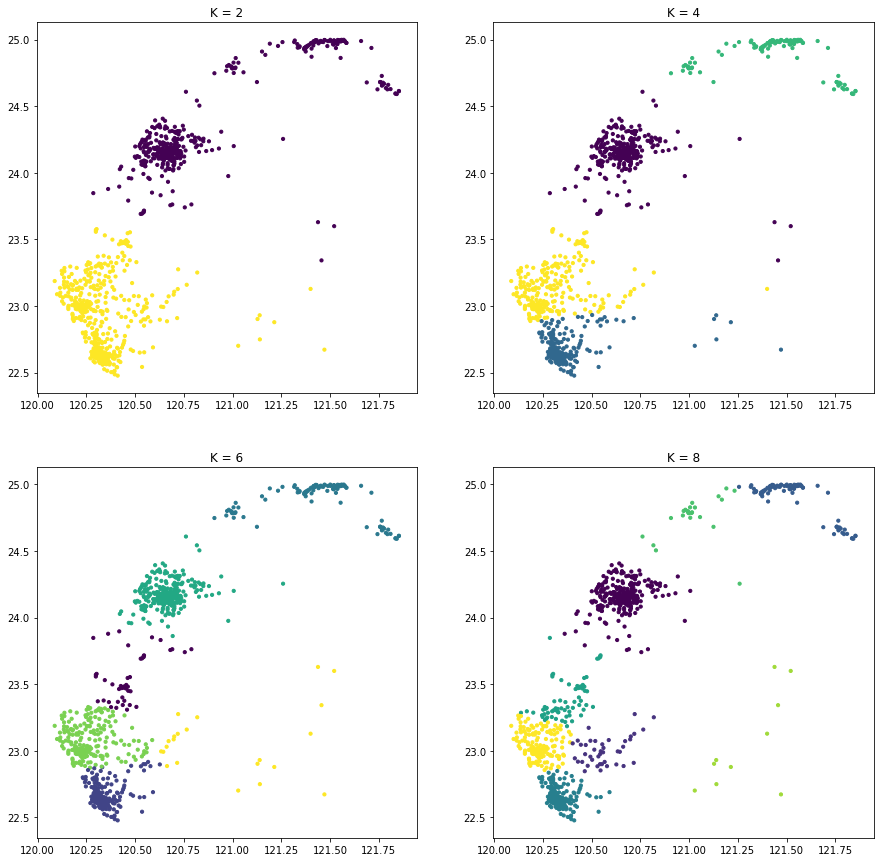

In [7]:
maxK = 10
x, y = coords[:, 1], coords[:, 0]

fig = plt.figure(figsize=(15,15))
for i in range(2, 8 + 1, 2):
    plt.subplot(2, 2, int(i / 2))
    #draw_map()
    plt.title('K = ' + str(i))
    kmeans = KMeans(n_clusters=i).fit(coords)
    plt.scatter(x, y, c=kmeans.labels_, zorder=3, s=10)

### Silhouette method
    To determine what value of k will get good performance.

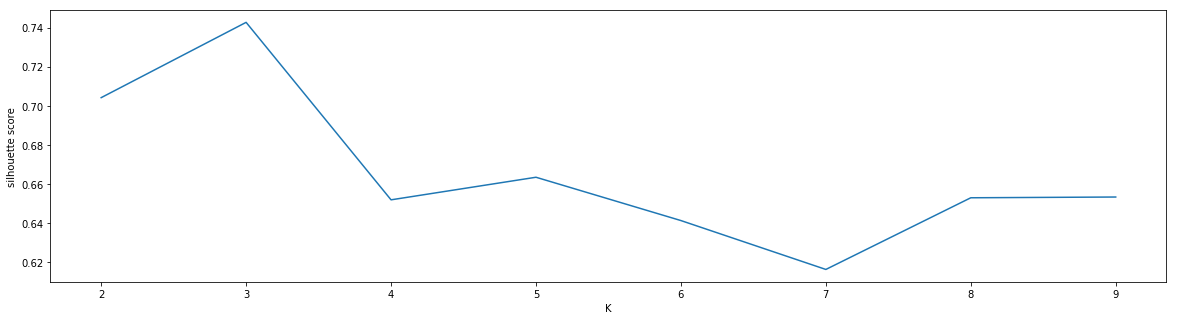

In [8]:
score = []

for k in range(2, maxK):
    kmeans = KMeans(n_clusters=k).fit(coords)
    score.append(metrics.silhouette_score(coords, kmeans.labels_))
    
fig = plt.figure(figsize=(20,5))
plt.xlabel('K')
plt.ylabel('silhouette score')
plt.plot(range(2, maxK), score)
plt.show()

#畫出來越高代表效果越好 : k = 3比較好

Silhouette method illustrates that the clustering performance will be the best when K = 3. So we choose K = 3 to plot the result as below.

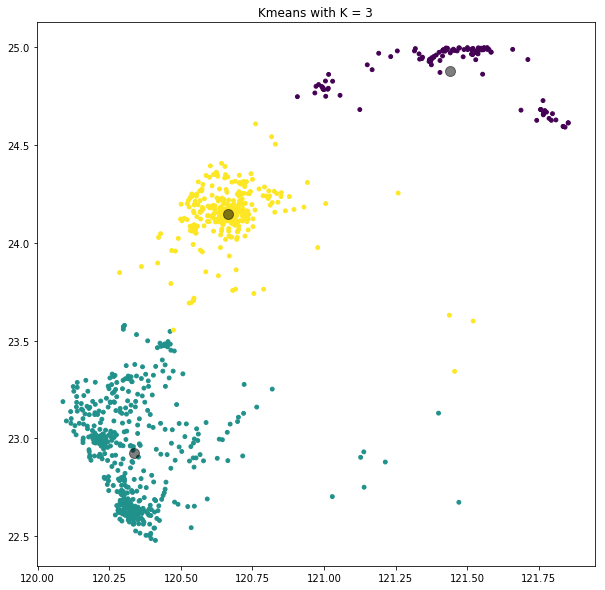

In [9]:
kmeans = KMeans(n_clusters=3).fit(coords)
fig = plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=kmeans.labels_, s=15, zorder=3)

centers = kmeans.cluster_centers_
centerX, centerY = centers[:, 1], centers[:, 0]
plt.scatter(centerX, centerY, c='black', s=100, alpha=0.5, zorder=4),

plt.title('Kmeans with K = ' + str(3))
plt.show()

## Comment
    As being displayed in the plot above, when K = 3, the clustering is mainly divided into three clusters, which is the north, the middle, and the south of Taiwan. It makes sense since the air pollution mostly occured in these regions, and the PM2.5 device is located in these places to warn people that the air condition is terrible. The east of Taiwan in the figure above has no device locates. It may because that the air condition here is usually great. So it has no need to put so many PM2.5 devices as the north, the middle, and the sourth of Taiwan.

# DBSCAN


In [10]:
def plot_DBscan(db):
    labels = db.labels_
   
    sizes = [3 if l == -1 else 30 for l in db.labels_]
    plt.scatter(x, y, c=db.labels_, zorder=3, s=sizes)


## Fix eps， and tune the min_samples
    1. Use haversine as the metric, which is because the (lat, lon) data is the latitude and logntitude value. The calculation should consider the earth is a sphere.
    2. Use eps 0.08, which is the experimental result to have better clustering performance. If the value is too big, all the points will be classified into one cluster, and if the value is too small, all the points will be classified as noise.

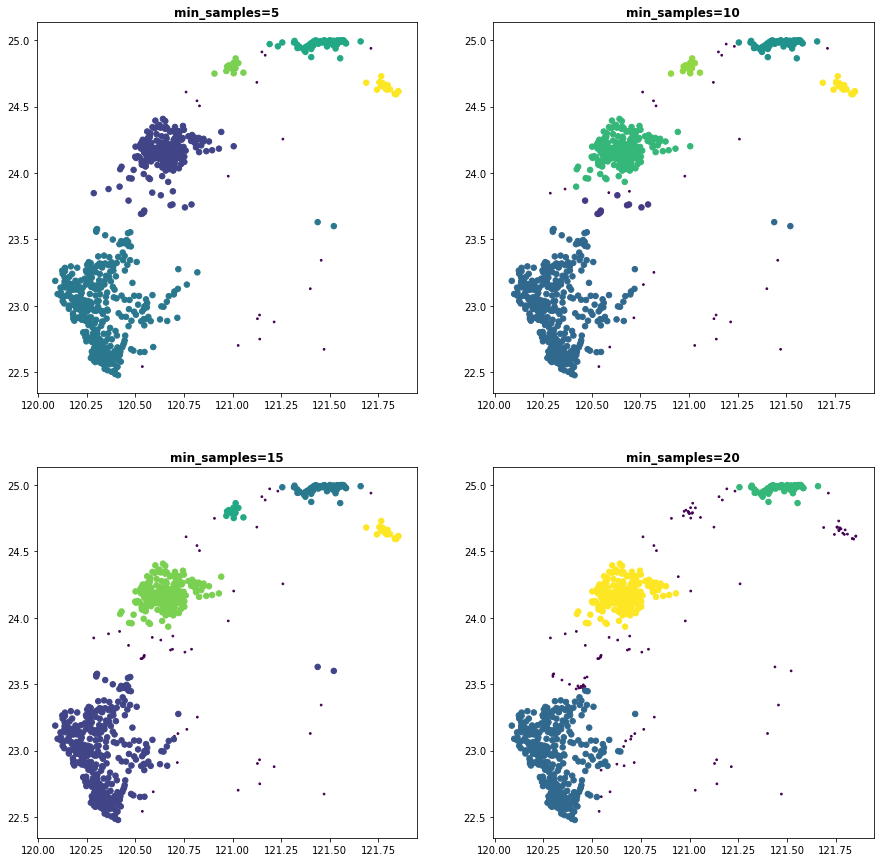

In [11]:
fig = plt.figure(figsize=(15,15))
fix_eps = 0.08
for min_sample in range(5, 5+20, 5):
    plt.subplot(2, 2, ((min_sample - 5) / 5)+1)
    db = DBSCAN(eps=fix_eps, min_samples=min_sample, metric='haversine').fit(coords)

    plot_DBscan(db)
    plt.title('min_samples='+str(min_sample), fontweight='bold') 

## Comment

    It shows better performance when min_samples = 20. It classified the points into the north, the middle, and the sourth region of Taiwan.

## Fix min_samples = 20， and tune the eps from 0.05 to 0.12
    1. Use haversine as the metric, which is because the (lat, lon) data is the latitude and logntitude value. The calculation should consider the earth is a sphere.
    2. Use min_samples = 20, which is the experimental result to have better clustering performance. If the value is too big, all the points will be classified into noise, and if the value is too small, all the points will be classified into one cluster.

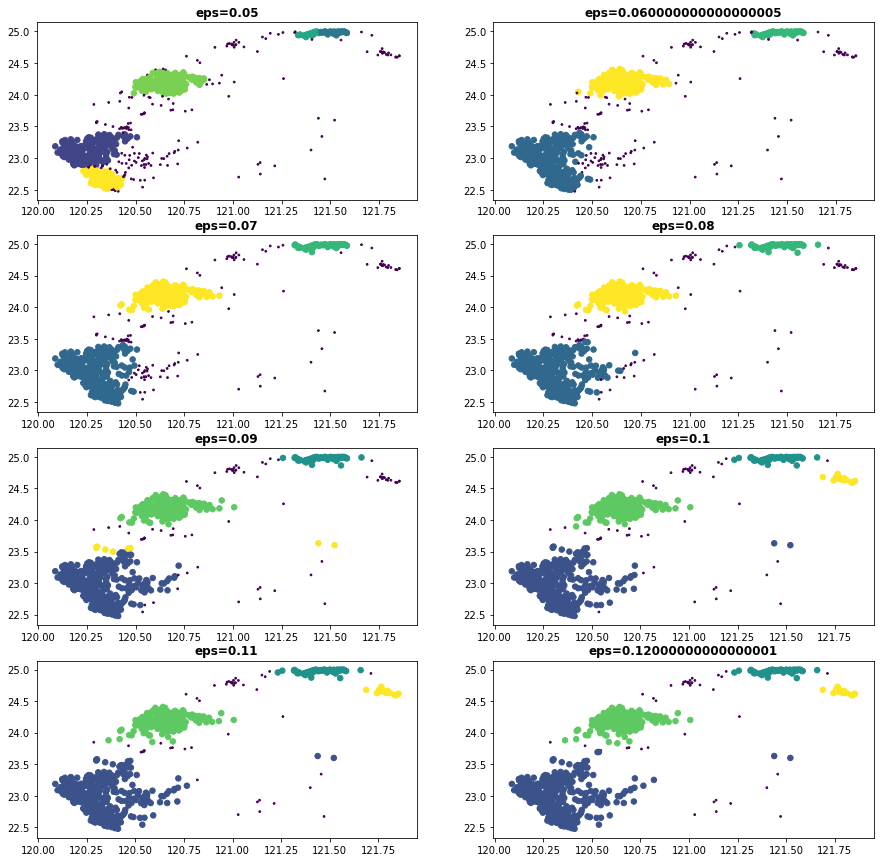

In [12]:
fix_min_samples = 20
eps_base = 5 * 1e-2
fig = plt.figure(figsize=(15, 15))

for eps in range(0, 8, 1):
    plt.subplot(4, 2, eps+1)
    eps = eps * 1e-2 + eps_base
    db = DBSCAN(eps=eps, min_samples=fix_min_samples, metric='haversine').fit(coords)

    plot_DBscan(db)
    plt.title('eps='+str(eps), fontweight='bold')  

## Comment
    The result shows that eps = 0.08 will have better performance than other vlaues. It can divide the divices to three main region : the north, the middle, and the sourth of Taiwan.

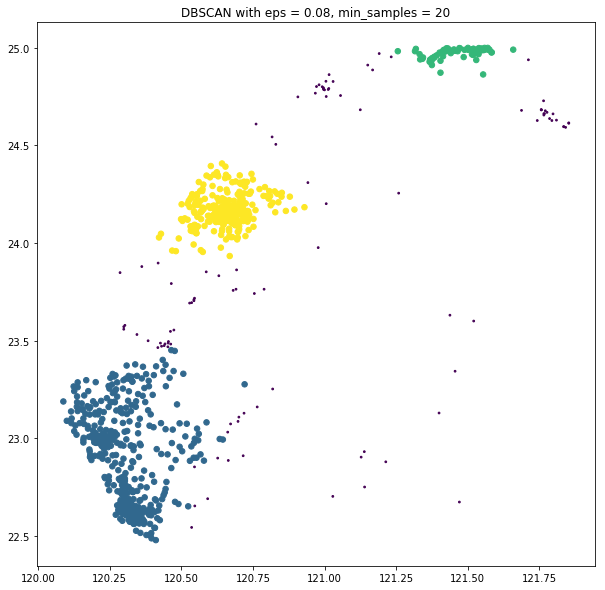

In [13]:
fix_min_samples = 20
eps = 8 * 1e-2

db = DBSCAN(eps=eps, min_samples=fix_min_samples, metric='haversine').fit(coords)
fig = plt.figure(figsize=(10, 10))
plot_DBscan(db)

plt.title('DBSCAN with eps = ' + str(8*1e-2) + ', min_samples = '+ str(20))
plt.show()

## Conclusion
    The devices location is mainly distributed in the north, the middle, and the south of Taiwan. KMeans algorithm shows good performance when K = 3 because the devices location meets its property, which is every data in each of the 3 clusters has minimum distance to its owned cluster's center. DBSCAN has good performance when eps = 0.8 and min_samples = 20. It shows more noise which does not belong to any of the three clusters due to no points is reachable to these noise. I think DBSCAN has better performance than KMeans because some noise is located in the east of Taiwan which is classified as in the middle or the south of Taiwan when applying KMeans. Compared with it, DBSCAN consider these points as noise rather than the middle or the south, which is because that none of the points in these regions are reachable to these points, and these points do not have enough density to form a cluster themselves. DBSCAN result shows that the east of Taiwan has much less devices compared with the north, the middle, and the sourth of Taiwan.